# Scipy

In [2]:
import numpy as np 
import scipy
from scipy import io as sio
from matplotlib import pyplot as plt
%matplotlib inline

# Optimization and fit:

 Optimization とは、最小化や等価性の数値的解法を探す問題です。
 __scipy.optimize__  のモジュールは（１次元、もしくは多次元の）minimization(最小化)、curve fitting(曲線近似)、root finding(求根) をする有用なアルゴリズムの機能が備わっています。


In [3]:
from scipy import optimize

## Finding the minimum of a scalar function
以下のような関数 $$ f(x) = x^2 + 10*sin(x)  $$ を定義します。

In [4]:
def f(x): return x**2 + 10*np.sin(x)

描画すると、

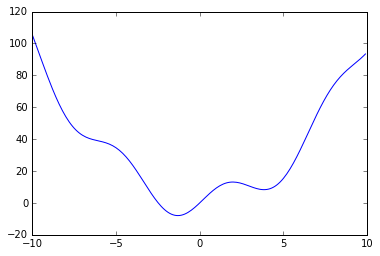

In [5]:
x = np.arange(-10,10,0.1)
plt.plot(x,f(x),linestyle="-")

　これは大域的最小値が -1.3、局所的最小値が 3.8 辺りにある事が見て取れます。

　この関数の最小値を求めるとき、一般的かつ効果的方法として、与えられた初期点から始まる勾配の減少を導く方法が挙げられます。BFGSアルゴリズム(準ニュートン法のアルゴリズムの一つ)がこれを実行する良い方法でしょう。
  
  
  *準ニュートン法：連続最適化問題の関数の極大、極小解を見つけるためのアルゴリズム。準ニュートン法はニュートン法を元にしており、関数の勾配が０になるという意味での関数の不動点を見つけるための方法の一種である。*

参照：
https://ja.wikipedia.org/wiki/%E6%BA%96%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%88%E3%83%B3%E6%B3%95

In [6]:
optimize.fmin_bfgs(f, 0) # 初期点 0 から解を探索する

Optimization terminated successfully.
         Current function value: -7.945823
         Iterations: 5
         Function evaluations: 24
         Gradient evaluations: 8


array([-1.30644003])

　このアプローチにおける有り得る問題として、もし関数が局所解を持っていたとすると、このアルゴリズムは初期点の位置によっては大域解の代わりに局所解を見つけてくるかもしれないという事がある。

In [7]:
optimize.fmin_bfgs(f,3,disp=0)

array([ 3.83746663])

　もし初期点選びの際に大域解の近傍がわからなければ、costlier global optimization（より費用の掛かる大域的最適化？）に頼る必要が出てきます。大域解を見つけるために、 *scipy.optimize.basinhopping()* を用いましょう。

In [8]:
optimize.basinhopping(f,0)

                        fun: -7.9458233756152845
 lowest_optimization_result:       fun: -7.9458233756152845
 hess_inv: array([[ 0.0858157]])
      jac: array([  1.19209290e-07])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([-1.30644001])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 1719
                        nit: 100
                       njev: 573
                          x: array([-1.30644001])

　他の大域解最適化の解法として、 *scipy.optimize.brute()* があります。
 その他にもより効果的なアルゴリズムが存在するのですが、scipyの領分を超えるようです。(OpenOpt,IPOPT,PyGMO,PyEvolve)

In [9]:
grid = (-10, 10, 0.1)
xmin_global = optimize.brute(f, (grid,))
print("global minimum: " + str(xmin_global[0]))

global minimum: -1.30641113281


　局所解を見つけるとき、*scipy.optimize.fminbound()* を使いましょう。

In [10]:
xmin_local = optimize.fminbound(f, 0., 10.)
xmin_local

3.8374671194983834

　関数の最小解の探索は Scipy Lecture Note の 2.7 章においてより詳細について記述されています。

## Finding the roots of a scalar function
　前述の関数 f の根を見つけるために、例えば *scipy.optimize.fsolve()* が使えます。

In [11]:
root = optimize.fsolve(f, 0)
root

array([ 0.])

　この方法では一つの根しか見つからない事に注意してください。 f のプロットをよく見ると、 -2.5 辺りに二つ目の根があることがわかります。では、初期値を調節することで正しい値を調べましょう。

In [12]:
root2 = optimize.fsolve(f,-2.5)
root2

array([-2.47948183])

## Curve fitting
　いくらかのノイズを含んだ、 f からサンプリングしたデータがあるとしましょう。

In [13]:
xdata = np.linspace(-10, 10, num=20)
ydata = f(xdata) + np.random.randn(xdata.size)
print(xdata)
print(ydata)

[-10.          -8.94736842  -7.89473684  -6.84210526  -5.78947368
  -4.73684211  -3.68421053  -2.63157895  -1.57894737  -0.52631579
   0.52631579   1.57894737   2.63157895   3.68421053   4.73684211
   5.78947368   6.84210526   7.89473684   8.94736842  10.        ]
[ 105.69900974   74.26905822   52.37979378   41.39879794   38.93158346
   33.20088473   19.5191631     2.42705742   -7.14360641   -3.58402856
    4.57519391   10.0135853    10.93387431    7.70883216   13.96302734
   30.60948335   51.80686592   71.92679977   85.08985937   93.4075233 ]


　今、amplitudes of the terms(区間の振れ幅？)ではなく、描かれたサンプルから関数の関数形式を知っているならば、最小二乗法によってこれらを見つけることができます。そのために先ず、次のような関数を定義します。

In [14]:
def f5(x,a,b):
    return a*x**2 + b*np.sin(x)

　ここで、*scipy.optimize.curve_fit()* を用いることで a と b を見つけることができます。

In [15]:
guess = [2, 2]
params, params_covariance = optimize.curve_fit(f5, xdata, ydata, guess)
params

array([ 0.99870407,  9.58413376])

　さて、f の最小値と根が見つかり、それに曲線当てはめを使ったところで、結果を一つのプロットにまとめましょう。

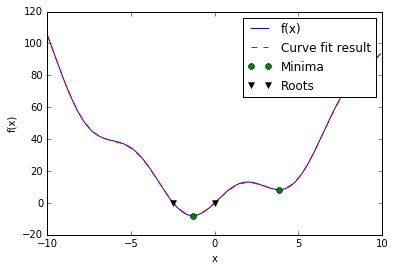

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, f(x), 'b-', label="f(x)")
ax.plot(x, f5(x, *params), 'r--', label="Curve fit result")
xmins = np.array([xmin_global[0], xmin_local])
ax.plot(xmins, f(xmins), 'go', label="Minima")
roots = np.array([root, root2])
ax.plot(roots, f(roots), 'kv', label="Roots")
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('f(x)')

# 演習問題  

## Curve fitting of temperature data
　アラスカの各月の最高、最低気温について以下の問に答えよ。
 - このデータをプロットせよ。
 - 最高気温、最低気温を描画できる関数を定義せよ。
 - curve_fit() を使い、この関数をデータに当てはめよ。
 - 結果をプロットせよ。また、この当てはめは妥当か否か。
 - Is the time offset for min and max temperatures the same within the fit accuracy?

In [17]:
months = np.arange(12) + 1
maxT = np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
minT = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])

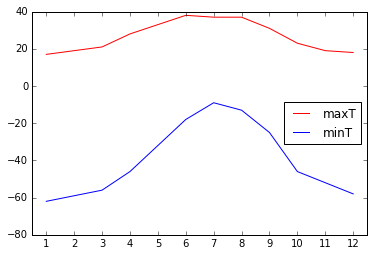

In [18]:
plt.plot(months, maxT, color="red", label="maxT")
plt.plot(months, minT, color="blue",label="minT")
plt.xlim(0.5, 12.5)
plt.xticks(months)
plt.legend(loc = 'best')

In [19]:
def gSHAPE(x,a1,b1,t1,c):
    return a1*np.sin(b1*x + t1) + c

In [20]:
p1, params_covariance1 = optimize.curve_fit(gSHAPE,months,maxT,[10,0.571,2.141,20])
p2, params_covariance2 = optimize.curve_fit(gSHAPE,months,minT,[1,1,1,1])
print(p1)
print(p2)

[ 10.58169955   0.59227423   3.87225535  27.94963524]
[ 25.14961999  -5.68186441  47.54705993 -36.71256604]


In [21]:
def gCF(x,p):
    return gSHAPE(x,*p)

maxF = minF = []
for i in months:
    maxF = np.append(maxF, gCF(i,p1))
    minF = np.append(minF, gCF(i,p2))

print(maxF)

[ 17.6913146   17.98936513  21.68041677  27.50709977  33.48453405
  37.57648554  38.38901656  35.64533555  30.28008711  24.12096204
  19.26608798  17.36929489]


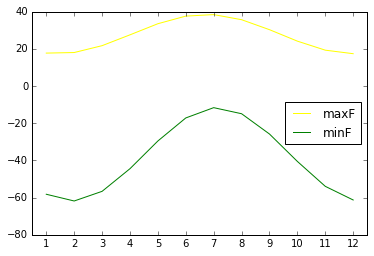

In [22]:
plt.plot(months, maxF,color="yellow",label='maxF')
plt.plot(months, minF,color="green",label='minF')
plt.xlim(0.5, 12.5)
plt.xticks(months)
plt.legend(loc = 'best')

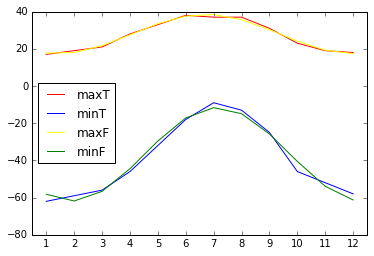

In [23]:
plt.plot(months, maxT, color="red", label="maxT")
plt.plot(months, minT, color="blue",label="minT")
plt.plot(months, maxF,color="yellow",label='maxF')
plt.plot(months, minF,color="green",label='minF')
plt.xlim(0.5, 12.5)
plt.xticks(months)
plt.legend(loc = 'best')

In [24]:
print(np.allclose(maxT,maxF))
print(np.allclose(minT,minF))

False
False


## 2-D minimization

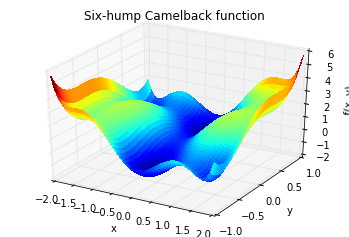

In [25]:
from mpl_toolkits.mplot3d import Axes3D

def sixhump(x):
    return (4 - 2.1*x[0]**2 + x[0]**4 / 3.) * x[0]**2 + x[0] * x[1] + (-4 + \
        4*x[1]**2) * x[1] **2

x = np.linspace(-2, 2)
y = np.linspace(-1, 1)
xg, yg = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(xg, yg, sixhump([xg, yg]), rstride=1, cstride=1,
                       cmap=plt.cm.jet, linewidth=0, antialiased=False)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
ax.set_title('Six-hump Camelback function')

$$ f(x, y) = (4 - 2.1x^2 + \frac{x^4}{3})x^2 + xy + (4y^2 - 4)y^2 $$
は、複数の大域的最小値、局所的最小値を持つ。この関数の大域解を求めよ。

In [26]:
def h(z):
    x,y = z
    return (4 - 2.1*x**2 + (1/3)*x**4)*x**2 + x*y + (4*y**2 - 4)*y**2

In [27]:
rrange = (slice(-2,2,0.1),slice(-1,1,0.1))
resbrute = optimize.brute(h, rrange, full_output=True,finish=optimize.fmin)
resbrute[0]

array([-0.08981556,  0.71264609])